In [1]:
! pip3 install --upgrade pip
! pip install qiskit qiskit-nature
import qiskit
! pip install qiskit-aer
! pip install pyscf
! pip install qiskit.algorithms
! pip install pylatexenc
! pip install matplotlib ipywidgets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 7.6 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 23.1.2
    Uninstalling pip-23.1.2:
      Successfully uninstalled pip-23.1.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 78.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 70.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 308.6/308.6 kB 20.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 34.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.4/39.4 MB 19.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.5/107.5 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 25.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.6/48.6 MB 9.8 MB/s eta 0

Getting some necessary imports

In [2]:
import qiskit_nature
import numpy as np
from qiskit_algorithms.optimizers import SLSQP
from qiskit_algorithms.minimum_eigensolvers import NumPyMinimumEigensolver, VQE
from qiskit_nature.second_q.transformers import FreezeCoreTransformer
from qiskit_nature.second_q.formats.molecule_info import MoleculeInfo
from qiskit_nature.second_q.mappers import ParityMapper
from qiskit_nature.second_q.circuit.library import UCCSD, HartreeFock

qiskit_nature.settings.use_pauli_sum_op = False

from qiskit_nature.second_q.drivers import PySCFDriver
import matplotlib.pyplot as plt
from qiskit.circuit.library import EfficientSU2

# VQE: the code architecture
**Quantum part**
1. Define hamiltonian
2. find lowest state, ref values
3. parameters for ansatz
4. define ansatz
5. measurements

**Classical Part**
6. run optimiser
7. Find estimated lowest eigenvalue


In [3]:
def get_qubit_op(dist):
    # Define Molecule
    molecule = MoleculeInfo(
        # Coordinates in Angstrom
        symbols=["Li", "H"],
        coords=([0.0, 0.0, 0.0], [dist, 0.0, 0.0]),
        multiplicity=1,  # = 2*spin + 1
        charge=0,
    )

    driver = PySCFDriver.from_molecule(molecule)

    # Get properties
    properties = driver.run()

    # Reduce number of qubits used -> freeze core & remove 2 unoccupied orbitals
    problem = FreezeCoreTransformer(
        freeze_core=True, remove_orbitals=[-3, -2]
    ).transform(properties)

    num_particles = problem.num_particles
    num_spatial_orbitals = problem.num_spatial_orbitals

    mapper = ParityMapper(num_particles=num_particles)
    qubit_op = mapper.map(problem.second_q_ops()[0])
    return qubit_op, num_particles, num_spatial_orbitals, problem, mapper


In [4]:
from qiskit_aer.primitives import Estimator

#exact GSE is calculated on qubit operator and classical exact eigensolver.
#exact eigensolver (full config interaction (fci)): calculates exact eigenvalues and eigenvectos
def exact_solver(qubit_op, problem):
    sol = NumPyMinimumEigensolver().compute_minimum_eigenvalue(qubit_op)
    result = problem.interpret(sol)
    return result   # initial state |psi> is created -> VQE uses to produce final ansatz = min_theta (|psi(theta)>)


distances = np.arange(0.5, 4.0, 0.2)
exact_energies = []
vqe_energies = []
optimizer = SLSQP(maxiter=10)
noiseless_estimator = Estimator(approximation=True)

for dist in distances:
    (qubit_op, num_particles, num_spatial_orbitals, problem, mapper) = get_qubit_op(
        dist
    )

    result = exact_solver(qubit_op, problem)
    exact_energies.append(result.total_energies[0].real)
    init_state = HartreeFock(num_spatial_orbitals, num_particles, mapper)
    var_form = UCCSD(
        num_spatial_orbitals, num_particles, mapper, initial_state=init_state
    )
    vqe = VQE(
        noiseless_estimator,
        var_form,
        optimizer,
        initial_point=[0] * var_form.num_parameters,
    )
    vqe_calc = vqe.compute_minimum_eigenvalue(qubit_op)
    vqe_result = problem.interpret(vqe_calc).total_energies[0].real
    vqe_energies.append(vqe_result)
    print(
        f"Interatomic Distance: {np.round(dist, 2)}",
        f"VQE Result: {vqe_result:.8f}",
        f"Exact Energy: {exact_energies[-1]:.8f}",
    )

print("All energies have been calculated")


Interatomic Distance: 0.5 VQE Result: -7.04790959 Exact Energy: -7.04790988
Interatomic Distance: 0.7 VQE Result: -7.50399968 Exact Energy: -7.50399989
Interatomic Distance: 0.9 VQE Result: -7.72283455 Exact Energy: -7.72283459
Interatomic Distance: 1.1 VQE Result: -7.82520272 Exact Energy: -7.82520275
Interatomic Distance: 1.3 VQE Result: -7.86890403 Exact Energy: -7.86890408
Interatomic Distance: 1.5 VQE Result: -7.88213986 Exact Energy: -7.88213996
Interatomic Distance: 1.7 VQE Result: -7.87919778 Exact Energy: -7.87919787
Interatomic Distance: 1.9 VQE Result: -7.86798870 Exact Energy: -7.86798879
Interatomic Distance: 2.1 VQE Result: -7.85319622 Exact Energy: -7.85319625
Interatomic Distance: 2.3 VQE Result: -7.83772401 Exact Energy: -7.83772404
Interatomic Distance: 2.5 VQE Result: -7.82342684 Exact Energy: -7.82342694
Interatomic Distance: 2.7 VQE Result: -7.81142044 Exact Energy: -7.81142060
Interatomic Distance: 2.9 VQE Result: -7.80214656 Exact Energy: -7.80214665
Interatomic 

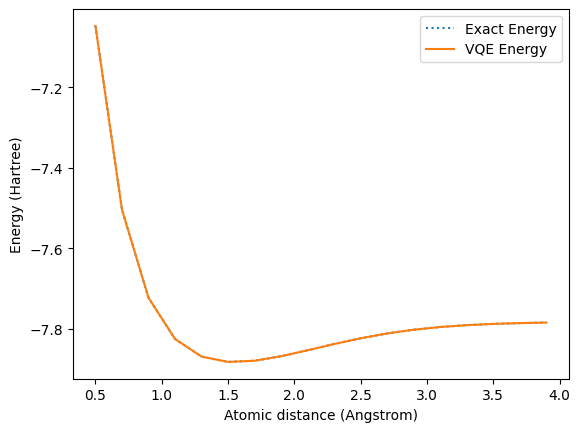

In [6]:
plt.plot(distances, exact_energies, linestyle=':', label="Exact Energy")
plt.plot(distances, vqe_energies, label="VQE Energy")
plt.xlabel("Atomic distance (Angstrom)")
plt.ylabel("Energy (Hartree)")
plt.legend()
plt.show()